In [202]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from keras.layers import LSTM, GRU, Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-07-07,23.924999,24.125000,23.905001,23.985001,22.146893,100558400
2016-07-08,24.122499,24.222500,24.012501,24.170000,22.317719,115648400
2016-07-11,24.187500,24.412500,24.182501,24.245001,22.386976,95179600
2016-07-12,24.292500,24.424999,24.280001,24.355000,22.488546,96670000
2016-07-13,24.352501,24.417500,24.209999,24.217501,22.361578,103568800
...,...,...,...,...,...,...
2023-06-30,191.630005,194.479996,191.259995,193.970001,193.970001,85069600
2023-07-03,193.779999,193.880005,191.759995,192.460007,192.460007,31458200
2023-07-05,191.570007,192.979996,190.619995,191.330002,191.330002,46920300


In [203]:
# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to create sequences for LSTM and GRU models
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)


# Define sequence length
sequence_length = 20

# Create sequences for LSTM and GRU models
X_train, y_train = create_dataset(train_data, sequence_length)
X_test, y_test = create_dataset(test_data, sequence_length)

In [204]:
# Function for get Bid and Ask
def get_prices(prices, predictions, threshold):
    buy_prices = []
    sell_prices = []

    for i in range(len(predictions)):
        if predictions[i] > prices[i] + threshold:
            sell_prices.append(prices[i])
        elif predictions[i] < prices[i] - threshold:
            buy_prices.append(prices[i])

    return buy_prices, sell_prices


# Define the trading strategy
def trading_strategy(actual_prices, predicted_prices):
    signal = np.zeros(len(actual_prices))
    for i in range(1, len(actual_prices)):
        if predicted_prices[i] > actual_prices[i - 1]:
            signal[i] = 1
        elif predicted_prices[i] < actual_prices[i - 1]:
            signal[i] = -1
    return signal

11/11 [==============================] - 0s 2ms/step
RMSE: 4.924124772575995
MAE: 3.9634971962318764
R2: 0.8912217721674622


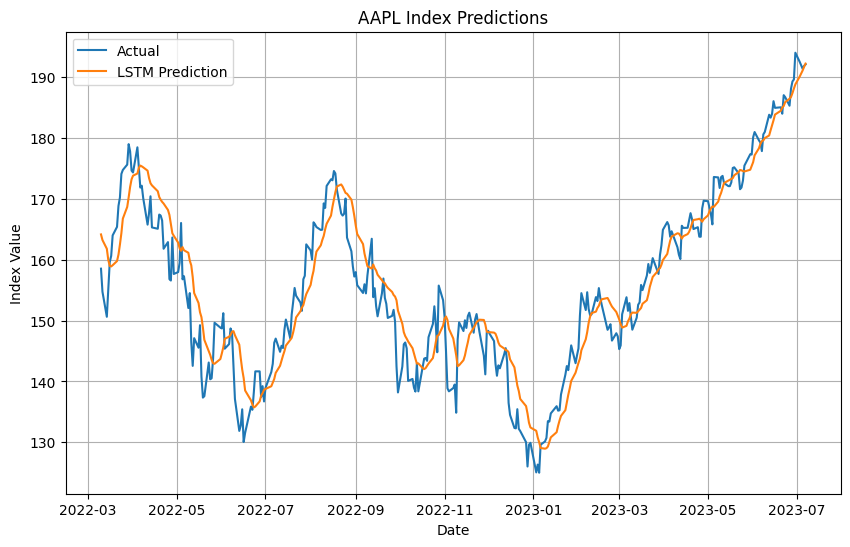

In [205]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Calculate indexes
lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
lstm_mae = mean_absolute_error(data[train_size + sequence_length:], lstm_predictions)
lstm_r2 = r2_score(data[train_size + sequence_length:], lstm_predictions)
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R2: {lstm_r2}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size + sequence_length:], data[train_size + sequence_length:], label='Actual')
plt.plot(dataset.index[train_size + sequence_length:], lstm_predictions, label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()

Buy Prices:
[172.7899932861328, 172.5500030517578, 178.9600067138672, 177.77000427246094, 174.61000061035156, 174.30999755859375, 178.44000244140625, 175.05999755859375, 171.8300018310547, 172.13999938964844, 170.39999389648438, 165.07000732421875, 167.39999389648438, 167.22999572753906, 166.4199981689453, 161.7899932861328, 162.8800048828125, 156.8000030517578, 156.57000732421875, 163.63999938964844, 157.64999389648438, 157.9600067138672, 159.47999572753906, 166.02000427246094, 156.77000427246094, 157.27999877929688, 149.63999938964844, 148.83999633789062, 148.7100067138672, 151.2100067138672, 172.10000610351562, 173.19000244140625, 173.02999877929688, 174.5500030517578, 174.14999389648438, 171.52000427246094, 167.57000732421875, 167.22999572753906, 167.52999877929688, 170.02999877929688, 157.3699951171875, 163.42999267578125, 155.30999755859375, 154.47999572753906, 156.89999389648438, 153.72000122070312, 152.74000549316406, 151.07000732421875, 148.02999877929688, 148.30999755859375, 

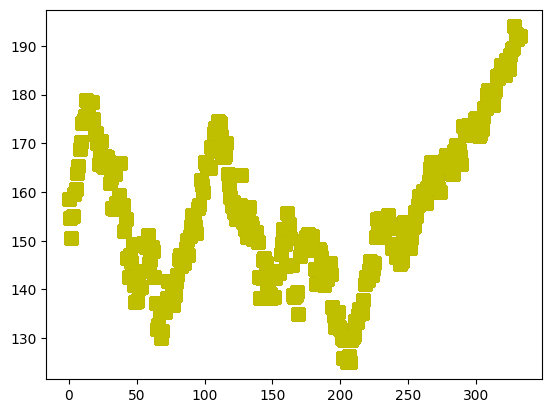

In [206]:
# Apply simple trading strategy
threshold = 10  # Adjust the threshold as needed
buy_prices, sell_prices = get_prices(dataset['Close'][train_size + 1:], lstm_predictions, threshold)

# Plot strategy
lstm_signal = trading_strategy(data[train_size + sequence_length:], lstm_predictions)
# plt.plot(np.where(lstm_signal == 1, data[train_size + sequence_length:], None), 'ms', markersize=8, label='LSTM Buy')
# plt.plot(np.where(lstm_signal == -1, data[train_size + sequence_length:], None), 'ys', markersize=8, label='LSTM Sell')

# Print buy and sell prices
print("Buy Prices:")
print(buy_prices)
print("Sell Prices:")
print(sell_prices)

11/11 [==============================] - 1s 2ms/step
RMSE: 3.6860516327697703
MAE: 2.865300267308324
R2: 0.939045368526916


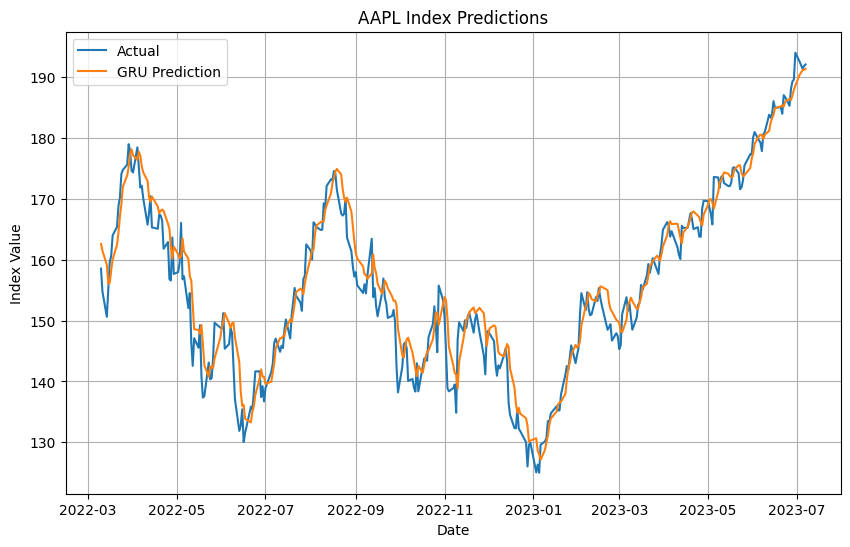

In [207]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(sequence_length, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Generate predictions for the GRU model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Calculate indexes
gru_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], gru_predictions))
gru_mae = mean_absolute_error(data[train_size + sequence_length:], gru_predictions)
gru_r2 = r2_score(data[train_size + sequence_length:], gru_predictions)
print(f"RMSE: {gru_rmse}")
print(f"MAE: {gru_mae}")
print(f"R2: {gru_r2}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size + sequence_length:], data[train_size + sequence_length:], label='Actual')
plt.plot(dataset.index[train_size + sequence_length:], gru_predictions, label='GRU Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()

Buy Prices:
[172.7899932861328, 172.5500030517578, 168.8800048828125, 178.9600067138672, 177.77000427246094, 174.61000061035156, 174.30999755859375, 178.44000244140625, 175.05999755859375, 171.8300018310547, 167.66000366210938, 170.39999389648438, 165.2899932861328, 165.07000732421875, 167.39999389648438, 167.22999572753906, 166.4199981689453, 161.7899932861328, 162.8800048828125, 156.8000030517578, 156.57000732421875, 163.63999938964844, 157.64999389648438, 157.9600067138672, 159.47999572753906, 166.02000427246094, 149.24000549316406, 151.2100067138672, 169.24000549316406, 168.49000549316406, 172.10000610351562, 173.19000244140625, 173.02999877929688, 174.5500030517578, 174.14999389648438, 171.52000427246094, 167.57000732421875, 167.22999572753906, 167.52999877929688, 170.02999877929688, 154.52999877929688, 155.9600067138672, 157.3699951171875, 163.42999267578125, 155.30999755859375, 152.3699951171875, 154.47999572753906, 156.89999389648438, 153.72000122070312, 150.17999267578125, 151

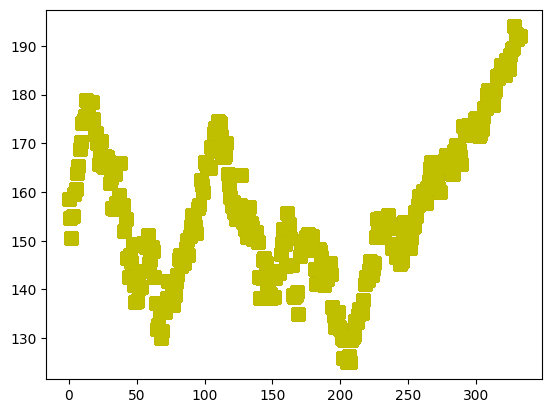

In [208]:
# Apply simple trading strategy
threshold = 10  # Adjust the threshold as needed
buy_prices, sell_prices = get_prices(dataset['Close'][train_size + 1:], gru_predictions, threshold)

# Plot strategy
gru_signal = trading_strategy(data[train_size + sequence_length:], gru_predictions)
# plt.plot(np.where(gru_signal == 1, data[train_size + sequence_length:], None), 'ms', markersize=8, label='GRU Buy')
# plt.plot(np.where(gru_signal == -1, data[train_size + sequence_length:], None), 'ys', markersize=8, label='GRU Sell')

# Print buy and sell prices
print("Buy Prices:")
print(buy_prices)
print("Sell Prices:")
print(sell_prices)

RMSE: 0.022640698185764287
MAE: 0.01733710946015705
R2: 0.9319024774634287


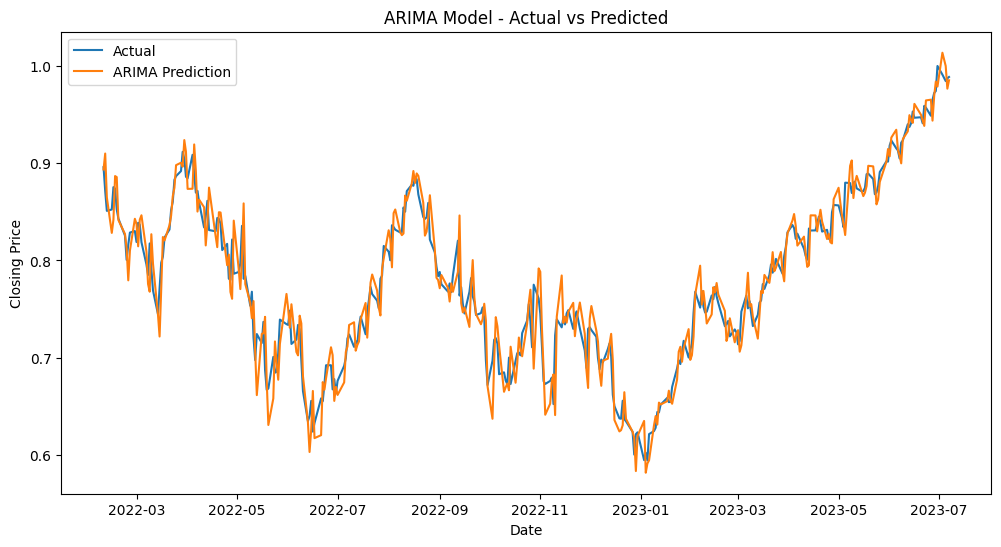

In [209]:
history = [x for x in train_data]
arima_predictions = []
for t in range(len(test_data)):
    model = ARIMA(history, order=(1, 2, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
arima_mae = mean_absolute_error(test_data, arima_predictions)
arima_r2 = r2_score(test_data, arima_predictions)
print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"R2: {arima_r2}")

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(dataset.index[train_size:], test_data, label='Actual')
plt.plot(dataset.index[train_size:], arima_predictions, label='ARIMA Prediction')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

Buy Prices:
[176.27999877929688, 172.1199951171875, 168.63999938964844, 168.8800048828125, 172.7899932861328, 172.5500030517578, 168.8800048828125, 167.3000030517578, 164.32000732421875, 160.07000732421875, 162.74000549316406, 164.85000610351562, 165.1199951171875, 163.1999969482422, 166.55999755859375, 166.22999572753906, 163.1699981689453, 159.3000030517578, 157.44000244140625, 162.9499969482422, 158.52000427246094, 154.72999572753906, 150.6199951171875, 155.08999633789062, 159.58999633789062, 160.6199951171875, 163.97999572753906, 165.3800048828125, 168.82000732421875, 170.2100067138672, 174.07000732421875, 174.72000122070312, 175.60000610351562, 178.9600067138672, 177.77000427246094, 174.61000061035156, 174.30999755859375, 178.44000244140625, 175.05999755859375, 171.8300018310547, 172.13999938964844, 170.08999633789062, 165.75, 167.66000366210938, 170.39999389648438, 165.2899932861328, 165.07000732421875, 167.39999389648438, 167.22999572753906, 166.4199981689453, 161.7899932861328,

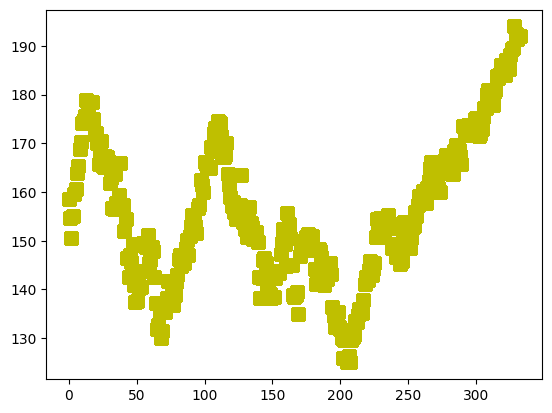

In [210]:
# Apply simple trading strategy
threshold = 10  # Adjust the threshold as needed
buy_prices, sell_prices = get_prices(dataset['Close'][train_size:], arima_predictions, threshold)

# Plot strategy
arima_signal = trading_strategy(data[train_size + sequence_length:], arima_predictions)
# plt.plot(np.where(arima_signal == 1, data[train_size + sequence_length:], None), 'ms', markersize=8, label='ARIMA Buy')
# plt.plot(np.where(arima_signal == -1, data[train_size + sequence_length:], None), 'ys', markersize=8, label='ARIMA Sell')

# Print buy and sell prices
print("Buy Prices:")
print(buy_prices)
print("Sell Prices:")
print(sell_prices)